# **Predicting Building Permit Issuance Times**
##                                                                                             ...and answering many questions!


**A Data Science Project**     
*by Aparna Shastry*

## Content 

+ Introduction / Scope
+ Predictive Modeling
+ Scope for Future Work
+ Conclusion
+ References

### Introduction / Scope of this Notebook
A detailed introduction to the problem, data and data cleaning part is explained in the first part of the project notebook in the same folder, by name BuildingPermitSFODataWrangling.ipynb  

Exploratory Data Analysis and Inferential Statistics is done in the second part of the notebook, BuildingPermitSFO-EDA.ipynb 

This notebook handles the predictive modeling part, and gives conclusions/scope for future work.

In [1]:
import os
import pandas as pd
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("talk")

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc, f1_score

C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Define a few sub-routines used below

In [2]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=2, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    #print(gs.grid_scores_)
    best = gs.best_estimator_
    return best


def pre_process_Xy(Xarray,yarray,test_tr_split_size=0.4,dev_test_split_size=0.5) :
    '''Function to split given data into test and (train, dev) set'''
    Xtr,Xte,ytr,yte = train_test_split(Xarray,yarray,test_size=test_tr_split_size,random_state=42,stratify=yarray)
    Xte,Xdev,yte,ydev = train_test_split(Xte,yte,test_size=dev_test_split_size,random_state=21,stratify=yte)
    return Xtr,Xdev,Xte,ytr,ydev,yte
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def plot_train_test_error(clf,X,y,N=50):
    '''This function plots Train and Test Accuracy for different lengths'''

    training_error = np.empty([N,1])
    dev_error = np.empty([N,1])
    len_tr = int(X.shape[0]/N)
    re_ind = np.random.permutation(X.index)
    X = X.reindex(re_ind)
    y = y.reindex(re_ind)
    for i in range(N) :
        X1 = X[:(i+1)*len_tr]
        y1 = y[:(i+1)*len_tr]
        Xtr,Xte,ytr,yte = train_test_split(X1,y1,test_size=0.5,random_state=42,stratify=y1)
        clf = clf.fit(Xtr, ytr)
        training_error[i,0] = 1 - clf.score(Xtr, ytr)
        dev_error[i,0] = 1 - clf.score(Xte, yte)
    
    plt.plot(np.arange(N)*len_tr,training_error.reshape(np.arange(N).shape),label='train error')
    plt.plot(np.arange(N)*len_tr,dev_error.reshape(np.arange(N).shape),color='m',label='test error')
    plt.title('Train Error and Test Error Vs Number of Samples used (train: test 1:1 ratio)')
    plt.ylabel('Error rate')
    plt.xlabel('Number of samples')
    plt.legend(loc='best')
    return
    
def do_classify(clf, parameters, Xtr,ytr,Xdev,ydev, score_func=None, n_folds=5, n_jobs=2,model_name='LogReg',label=1,prob_dec=1,print_detail=1):

    if parameters:
        clf = cv_optimize(clf, parameters, Xtr, ytr, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtr, ytr)
    training_accuracy = clf.score(Xtr, ytr)
    test_accuracy = clf.score(Xdev, ydev)
    ypred =  clf.predict(Xdev)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
    print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
    if print_detail == 1 :
        print("confusion_matrix on dev data")
        print(confusion_matrix(ydev,ypred))
        print("classification report on dev data")
        print(classification_report(ydev,ypred))
        print("########################################################")
    else :
        print("f1 score:  %0.2f" % f1_score(ydev,ypred,average="weighted"))
    return clf

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr.iloc[:,0].min(), Xtr.iloc[:,0].max()
    ymin, ymax= Xtr.iloc[:,1].min(), Xtr.iloc[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clf.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr.iloc[:, 0], Xtr.iloc[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte.iloc[:, 0], Xte.iloc[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)
    
def convert_categories(y) :
    '''Function to convert a numerical variable into 5 categories''' 
    if y < 8:
        z = 0
    elif y < 92 :
        z = 1
    else :
        z = 2
    return z
def convert_bin_categories(y) :
    '''Function to convert a numerical variable into 2 categories'''
    if y < 31:
        z = 0
    else :
        z = 1
    return z


#------------------------------------------------------------------------------#
# Function to plot Precision Recall curve for multiple classes                 #
#------------------------------------------------------------------------------#
# Use label_binarize to be multi-label like settings


In [3]:
# Retrieve Dataframe
%store -r sfr

In [4]:
sfr.head()

,perm_typ,perm_typ_def,file_dt,issue_dt,cur_st,strct_notif,no_exist_stry,no_prop_stry,fire_only_permit,est_cost,...,time_taken,file_day,issue_day,month,year,latitude,longitude,issue_mod,quarter,log_rev_cost
0,4,sign - erect,2015-05-06,2015-11-09,expired,N,6.0,NaN,N,4000.0,...,187,Wednesday,Monday,5,2015,37.785719,-122.408523,2015-11-09,2,8.294050
1,4,sign - erect,2016-04-19,2017-08-03,issued,N,7.0,NaN,N,1.0,...,471,Tuesday,Thursday,4,2016,37.787340,-122.410632,2017-08-03,2,6.214608
3,8,otc alterations permit,2016-11-07,2017-07-18,complete,N,2.0,2.0,N,2000.0,...,253,Monday,Tuesday,11,2016,37.795959,-122.415574,2017-07-18,4,7.600902
4,6,demolitions,2016-11-28,2017-12-01,issued,N,3.0,NaN,N,100000.0,...,368,Monday,Friday,11,2016,37.783153,-122.409509,2017-12-01,4,11.512925
5,8,otc alterations permit,2017-06-14,2017-07-06,issued,N,5.0,5.0,Y,4000.0,...,22,Wednesday,Thursday,6,2017,37.759223,-122.391704,2017-07-06,2,8.294050


### **Predictive Modeling**

This section tries to fit a model on the data to predict whether building permit will be issued within a week, 3 months or after 3 months. We could do some feature engineering first and keep them ready.

#### Feature Engineering

In [5]:
# Create Polynomial features:
sfr = sfr.assign(log_rev_cost_2 = sfr.log_rev_cost**2)
sfr = sfr.assign(log_rev_cost_3 = sfr.log_rev_cost**3)

In [6]:
# Generate some more features
sfr[sfr['exist_use'] != sfr['prop_use']].groupby('perm_typ').time_taken.describe()
sfr = sfr.assign(dff_use = 1*(sfr['exist_use'] != sfr['prop_use']))
sfr = sfr.assign(diff_stry=1*(sfr.no_prop_stry != sfr.no_exist_stry))

#### Defining Machine Learning Classification Problem

In [7]:
# Make target variable
y = sfr.loc[:,'time_taken'].copy()
y = y.apply(convert_categories)
y_dist = (y.value_counts()/y.count())
pd.DataFrame(np.round(y_dist,3))

,time_taken
0,0.718
1,0.151
2,0.130


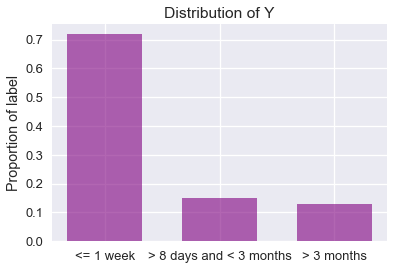

In [8]:
objects = ('<= 1 week', '> 8 days and < 3 months', '> 3 months')
y_pos = np.arange(len(objects))
performance = list(y_dist)
bar_width = 0.65
_ = plt.bar(y_pos, performance, bar_width,align='center', alpha=0.6,color='purple')
_ = plt.xticks(y_pos, objects)
_ = plt.ylabel('Proportion of label')
_ = plt.title('Distribution of Y')

#### Extract Predictors of interest

In [9]:
X = sfr[['log_rev_cost','log_rev_cost_2','log_rev_cost_3','perm_typ','file_day','month','plansets','site_permit','fire_only_permit','strct_notif','exist_const_type',
         'prop_const_type','dff_use','diff_stry','longitude','latitude']].copy()

In [10]:
Xlr = X.copy()
cat_vars = ['perm_typ','file_day','month','plansets','exist_const_type','prop_const_type']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(Xlr[var], prefix=var,drop_first=True)
    X1=Xlr.join(cat_list)
    Xlr=X1
Xlr.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped
Xlr['site_permit'] = Xlr['site_permit'].astype('category').cat.codes
Xlr['fire_only_permit'] = Xlr['fire_only_permit'].astype('category').cat.codes
Xlr['strct_notif'] = Xlr['strct_notif'].astype('category').cat.codes

# Standardizing numerical predictors for logistic regression
Xlr['log_rev_cost'] = Xlr['log_rev_cost'].transform(lambda x: (x - x.mean())/x.std())
Xlr['log_rev_cost_2'] = Xlr['log_rev_cost_2'].transform(lambda x: (x - x.mean())/x.std())
Xlr['log_rev_cost_3'] = Xlr['log_rev_cost_3'].transform(lambda x: (x - x.mean())/x.std())
Xlr = Xlr.drop(['log_rev_cost_3','longitude','exist_const_type_2.0','exist_const_type_3.0','exist_const_type_4.0','exist_const_type_5.0'],axis=1)

#### Examine Correlation

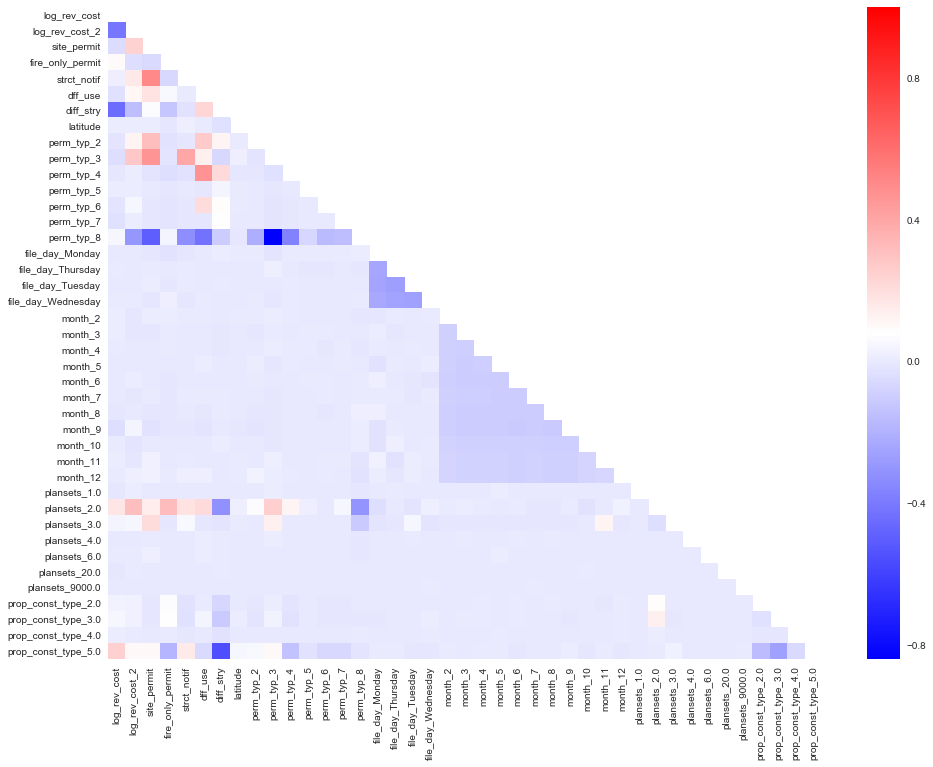

In [11]:
sns.set(style="white")
_ = plt.figure(figsize=(16,12))
mask = np.zeros_like(Xlr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
_ = sns.heatmap(Xlr.corr(),mask=mask,cmap='bwr')
sns.set(style="darkgrid")

In [12]:
# Call preprocess for logreg
Xl_tr,Xl_dev,Xl_te,yl_tr,yl_dev,yl_te = pre_process_Xy(Xlr,y)

#### Examine the Bias in Dataset

Wall time: 50.9 s


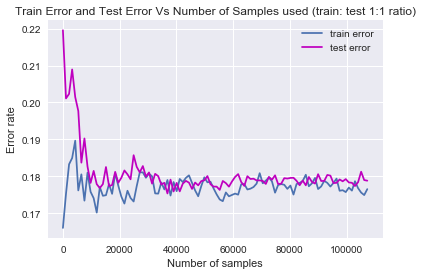

In [13]:
%%time
lr = LogisticRegression()
plot_train_test_error(lr,Xl_tr,yl_tr,N=100)

**Remarks:** The above plot indicates that pretty soon, with around 20,000 training samples, the error reaches steady state and model generalizes pretty well to test set. This gives a clue that high variance models might not be able to give considerable  performance boost compared to logistic regression.

In [14]:
%%time
parameters = {"C":[10,1000,10000],"class_weight":[None,'balanced']}
lr = do_classify(LogisticRegression(), parameters, Xl_tr,yl_tr,Xl_dev,yl_dev, score_func='f1_weighted', n_folds=10, n_jobs=-1,model_name='LogReg',label=1,prob_dec=1)

BEST {'C': 10000, 'class_weight': 'balanced'} 0.8114339064344989
############# based on standard predict ################
Accuracy on training data: 79.16%
Accuracy on test data:     78.82%
confusion_matrix on dev data
[[21222  4733    26]
 [  879  4125   469]
 [  323  1231  3155]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.95      0.82      0.88     25981
          1       0.41      0.75      0.53      5473
          2       0.86      0.67      0.75      4709

avg / total       0.85      0.79      0.81     36163

########################################################
Wall time: 2min 3s


#### Prepare the data for tree/ensemble based models. 

In [15]:
X['file_day'] = X['file_day'].astype('category').cat.codes
X['plansets'] = X['plansets'].astype('category').cat.codes
X['site_permit'] = X['site_permit'].astype('category').cat.codes
X['fire_only_permit'] = X['fire_only_permit'].astype('category').cat.codes
X['strct_notif'] = X['strct_notif'].astype('category').cat.codes
X['exist_const_type'] = X['exist_const_type'].astype('category').cat.codes
X['prop_const_type'] = X['prop_const_type'].astype('category').cat.codes
Xtr,Xdev,Xte,ytr,ydev,yte = pre_process_Xy(X,y)

In [16]:
%%time
parameters = {"max_depth": [12,14,None], 'min_samples_leaf': [1,2,4,6],"class_weight":[None,'balanced']}
tr = do_classify(DecisionTreeClassifier(), parameters, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=10, n_jobs=2,model_name='DecTree',label=1,prob_dec=1)

BEST {'class_weight': None, 'max_depth': 12, 'min_samples_leaf': 6} 0.8198562920039769
############# based on standard predict ################
Accuracy on training data: 83.68%
Accuracy on test data:     82.54%
confusion_matrix on dev data
[[24449  1472    60]
 [ 2840  2258   375]
 [  837   730  3142]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.87      0.94      0.90     25981
          1       0.51      0.41      0.45      5473
          2       0.88      0.67      0.76      4709

avg / total       0.82      0.83      0.82     36163

########################################################
Wall time: 2min 22s


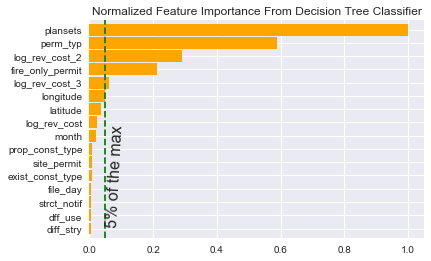

In [17]:
feature_labels = np.array(list(X.columns))
(pd.Series(tr.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(tr.feature_importances_)).plot.barh(color='orange',width=0.9)
_ = plt.title('Normalized Feature Importance From Decision Tree Classifier')
_ = plt.axvline(0.05,linestyle='--',color='g')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)

#### Evaluating the gains obtained by Feature Selection and Feature Engineering with Decision Trees

In [18]:
list_columns_by_importance = list((pd.Series(tr.feature_importances_,index=feature_labels).sort_values(ascending=False).index))
for i in np.arange(1,len(list_columns_by_importance)-1):
    columns_to_keep = list(list_columns_by_importance[:i])
    Xtr1 = Xtr[columns_to_keep]
    Xdev1 = Xdev[columns_to_keep]
    tr1 = do_classify(DecisionTreeClassifier(min_samples_leaf=6,class_weight=None, max_depth=12), None, Xtr1,ytr,Xdev1,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='DecTree',label=1,prob_dec=1,print_detail=0)

############# based on standard predict ################
Accuracy on training data: 71.98%
Accuracy on test data:     72.01%
f1 score:  0.60
############# based on standard predict ################
Accuracy on training data: 78.53%
Accuracy on test data:     78.40%
f1 score:  0.71


C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


############# based on standard predict ################
Accuracy on training data: 82.37%
Accuracy on test data:     82.06%
f1 score:  0.81
############# based on standard predict ################
Accuracy on training data: 82.76%
Accuracy on test data:     82.29%
f1 score:  0.81
############# based on standard predict ################
Accuracy on training data: 82.76%
Accuracy on test data:     82.29%
f1 score:  0.81
############# based on standard predict ################
Accuracy on training data: 83.25%
Accuracy on test data:     82.39%
f1 score:  0.81
############# based on standard predict ################
Accuracy on training data: 83.59%
Accuracy on test data:     82.45%
f1 score:  0.82
############# based on standard predict ################
Accuracy on training data: 83.59%
Accuracy on test data:     82.44%
f1 score:  0.82
############# based on standard predict ################
Accuracy on training data: 83.57%
Accuracy on test data:     82.56%
f1 score:  0.81
#############

**Remarks:** The features are added one by one starting from most important feature. After adding 4 most important feature, we see hardly any improvement.

#### Bagging Classifier

Bagging Classifier is something in between Decision Trees and Random Forests. It is tried before Random Forests, to gain understanding of what really makes difference.

In [19]:
%%time
parameters = {"n_estimators":[10,100,200]}
bag = do_classify(BaggingClassifier(), parameters, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='Bagging',label=1,prob_dec=1)

BEST {'n_estimators': 200} 0.83613364382764
############# based on standard predict ################
Accuracy on training data: 99.92%
Accuracy on test data:     84.67%
confusion_matrix on dev data
[[24391  1469   121]
 [ 2356  2798   319]
 [  693   587  3429]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.89      0.94      0.91     25981
          1       0.58      0.51      0.54      5473
          2       0.89      0.73      0.80      4709

avg / total       0.84      0.85      0.84     36163

########################################################
Wall time: 13min 50s


In [20]:
%%time
# This takes more than an hour to execute at times.
parameters =  {"max_depth": [12,14,None], 'min_samples_leaf': [1,2,4,6],"class_weight":[None,"balanced"],"n_estimators":[10,100,200,300]} #Including defaults
rf = do_classify(RandomForestClassifier(), parameters, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='RandomForest',label=1,prob_dec=1)

BEST {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 300} 0.8361511117971382
############# based on standard predict ################
Accuracy on training data: 95.36%
Accuracy on test data:     82.74%
confusion_matrix on dev data
[[22731  3121   129]
 [ 1339  3760   374]
 [  422   857  3430]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.93      0.87      0.90     25981
          1       0.49      0.69      0.57      5473
          2       0.87      0.73      0.79      4709

avg / total       0.85      0.83      0.84     36163

########################################################
Wall time: 1h 28min 32s


In [21]:
pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=False)

plansets            0.186183
perm_typ            0.127681
log_rev_cost_2      0.110661
longitude           0.104059
latitude            0.102293
log_rev_cost        0.091904
log_rev_cost_3      0.086461
month               0.053717
file_day            0.033707
fire_only_permit    0.023882
site_permit         0.020729
prop_const_type     0.018585
exist_const_type    0.017858
strct_notif         0.007738
diff_stry           0.007347
dff_use             0.007194
dtype: float64

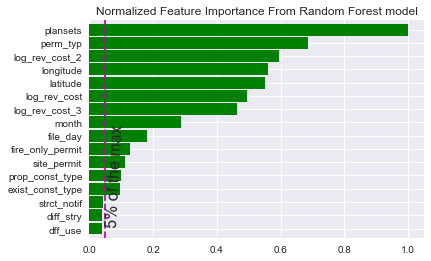

In [22]:
(pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(rf.feature_importances_)).plot.barh(color='g',width=0.9)
_ = plt.title('Normalized Feature Importance From Random Forest model')
_ = plt.axvline(0.05,linestyle='--',color='m')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)

#### Evaluating the gains obtained by Feature Selection and Feature Engineering with Random Forest

In [23]:
%%time
list_columns_by_importance = list((pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=False).index))
for i in np.arange(1,len(list_columns_by_importance)-4):
    columns_to_keep = list(list_columns_by_importance[:i])
    print(columns_to_keep)
    Xtr1 = Xtr[columns_to_keep]
    Xdev1 = Xdev[columns_to_keep]
    rf1 = do_classify(RandomForestClassifier(class_weight='balanced',max_depth=None,min_samples_leaf=2,n_estimators=200), None, Xtr1,ytr,Xdev1,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='RandForest',label=1,prob_dec=1,print_detail=0)

['plansets']
############# based on standard predict ################
Accuracy on training data: 63.78%
Accuracy on test data:     63.73%
f1 score:  0.65
['plansets', 'perm_typ']
############# based on standard predict ################
Accuracy on training data: 69.26%
Accuracy on test data:     68.94%
f1 score:  0.73
['plansets', 'perm_typ', 'log_rev_cost_2']
############# based on standard predict ################
Accuracy on training data: 75.34%
Accuracy on test data:     73.61%
f1 score:  0.77
['plansets', 'perm_typ', 'log_rev_cost_2', 'longitude']
############# based on standard predict ################
Accuracy on training data: 91.14%
Accuracy on test data:     79.92%
f1 score:  0.81
['plansets', 'perm_typ', 'log_rev_cost_2', 'longitude', 'latitude']
############# based on standard predict ################
Accuracy on training data: 94.82%
Accuracy on test data:     81.93%
f1 score:  0.83
['plansets', 'perm_typ', 'log_rev_cost_2', 'longitude', 'latitude', 'log_rev_cost']
######

**Remarks:** The five features [ 'plansets', 'perm_typ', 'log_rev_cost_2', 'longitude', 'latitude' ] consistently give improvements in accuracy and accuracy score. Out of the remaining, the amount of improvement attained changes with runs, as we have not fixed the random state. 

In [25]:
%%time
gb = do_classify(GradientBoostingClassifier(n_estimators=50), None, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='GradientBoosting',label=1,prob_dec=1) 

############# based on standard predict ################
Accuracy on training data: 82.89%
Accuracy on test data:     82.63%
confusion_matrix on dev data
[[24554  1408    19]
 [ 2908  2215   350]
 [  853   742  3114]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.87      0.95      0.90     25981
          1       0.51      0.40      0.45      5473
          2       0.89      0.66      0.76      4709

avg / total       0.82      0.83      0.82     36163

########################################################
Wall time: 16 s


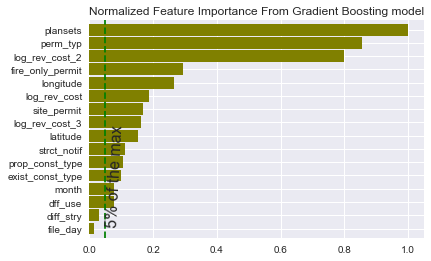

In [26]:
(pd.Series(gb.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(gb.feature_importances_)).plot.barh(color='olive',width=0.9)
_ = plt.title('Normalized Feature Importance From Gradient Boosting model')
_ = plt.axvline(0.05,linestyle='--',color='g')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)

## Scope for Future Work

+ Can gather more location based data, like housing price or crime data to reduce the bias
+ Try undersampling, oversampling techniques to handle class imbalance

## Conclusions

We did Data cleaning, EDA and inferential statistics on the data. Defined the time taken variable as a 3 - class classification problem, fitted a few models, did hyperparameter tuning and evaluated the performance. 

+ The Random Forest is the chosen model   
+ Wait times depend on Latitude and Longitude, this suggests correlation with location data, opens up several possibilities to collect more data
+ Logarithm of revised cost and its engineered versions are important features
+ Finally 5 features are found to be deterministic factors Plansets, Permit type, log_rev_cost_2, longitude, latitude. Sometimes when RandomForest can give slightly different important features, as seed is not fixed.

## References
1. [Population proportions Coursera](https://www.coursera.org/learn/inferential-statistics-intro/supplement/AphlU/lesson-learning-objectives)
2. [Quora Answer on Multi class](https://www.quora.com/In-multi-class-classification-what-are-pros-and-cons-of-One-to-Rest-and-One-to-One)
3. [Multinomial Logistic Regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)
4. [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)
5. [Machine Learning Coursera](https://www.coursera.org/learn/machine-learning/)
6. [Structuring Machine Learning Projects Coursera](https://www.coursera.org/learn/machine-learning-projects)
7. [Datacamp](https://www.datacamp.com) lectures, Springboard exercises

**Acknowledgment**

1. [Springboard](https://www.springboard.com/) team - Andrew, Chris, Guy Maskal and a few student friends - for the wonderful ecosystem!
2. Mentor [Rajiv Shah](http://rajivshah.com/) for driving this effort.